In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import os
import torch
import time

import pyro
import pyro.optim as optim
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO

from bayesian_rnn import BayesianSequenceModel
from utils.visualize import *

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda')

In [16]:
root = os.getcwd()
X_train, A_train, Y_train = np.load(root+"/../datasets/vanilla_rnn/train/states.npy"), np.load(root+"/../datasets/vanilla_rnn/train/actions.npy"), np.load(root+"/../datasets/vanilla_rnn/train/next_states.npy")
X_val, A_val, Y_val = np.load(root+"/../datasets/vanilla_rnn/val/states.npy"), np.load(root+"/../datasets/vanilla_rnn/val/actions.npy"), np.load(root+"/../datasets/vanilla_rnn/val/next_states.npy")
X_test, A_test, Y_test = np.load(root+"/../datasets/vanilla_rnn/test/states.npy"), np.load(root+"/../datasets/vanilla_rnn/test/actions.npy"), np.load(root+"/../datasets/vanilla_rnn/test/next_states.npy")

In [17]:
X_train.shape, A_train.shape, Y_train.shape

((160673, 100, 21), (160673, 100, 8), (160673, 100, 21))

In [18]:
X_val.shape, A_val.shape, Y_val.shape

((8927, 100, 21), (8927, 100, 8), (8927, 100, 21))

In [19]:
X_test.shape, A_test.shape, Y_test.shape

((8927, 100, 21), (8927, 100, 8), (8927, 100, 21))

In [20]:
vrnn = BayesianSequenceModel(num_steps=100, device=device).to(device)

In [21]:
vrnn.load_state_dict(torch.load(os.getcwd()+"/../models/vrnn_different_hyperparameters.pth"))

<All keys matched successfully>

In [22]:
adam = optim.Adam({"lr": 1.0e-3})
elbo = Trace_ELBO()
svi = SVI(vrnn.model, vrnn.guide, adam, loss=elbo)

In [23]:
# Do inference.
t0 = time.time()
epochs = 10000
batch_size = 1600
N = X_train.shape[0]

pyro.poutine.util.enable_validation(True)

X_example = torch.from_numpy(X_train[0:5]).to(device)
A_example = torch.from_numpy(A_train[0:5]).to(device)
Y_example = torch.from_numpy(Y_train[0:5]).to(device)

X=torch.from_numpy(X_train[:]).to(device)
A=torch.from_numpy(A_train[:]).to(device)
Y=torch.from_numpy(Y_train[:]).to(device)

for i in range(1, epochs+1):

    loss = svi.step(X=X, 
                    A=A, 
                    Y=Y, 
                    batch_size=batch_size)

    batch_loss, batch_Z, batch_Y_hat, batch_Y = vrnn.loss(X=X, A=A, Y=Y, batch_size=batch_size)
    print('i={}, epochs={:.2f}, elapsed={:.2f}, elbo={:.2f} loss={:.2f}'.format(
        i,
        (i * batch_size) / N,
        (time.time() - t0) / 3600,
        loss / N,
        batch_loss)
         )

    if i % 5 == 0:
        # compare_states(batch_Y[0], batch_Y_hat[0], overlap=True)            # animation of joints
        plot_velocity_curve(true=batch_Y[0, :, 0], pred=batch_Y_hat[0, :, 0]) # x-velocity
        # plot_velocity_curve(true=batch_Y[0, :, 1], pred=batch_Y_hat[0, :, 1]) # y-velocity
        # plot_velocity_curve(true=batch_Y[0, :, 2], pred=batch_Y_hat[0, :, 2]) # z-velocity

        # trace = poutine.trace(vrnn.guide).get_trace(X=X_example, A=A_example, Y=Y_example, batch_size=X_example.shape[0])
        # Y_hat_example, Z_example = poutine.replay(vrnn.prior, trace=trace)(X_example.shape[0])
        # print(Y_hat_example.shape)

        # Show data with inferred objection positions.
        # vis.images(draw_many(examples_to_viz, z_wheres))
        # Show reconstructions of data.
        # vis.images(draw_many(recons, z_wheres))
    '''
    if args.eval_every > 0 and i % args.eval_every == 0:
        # Measure accuracy on subset of training data.
        acc, counts, error_z, error_ix = count_accuracy(X, true_counts, air, 1000)
        print('i={}, accuracy={}, counts={}'.format(i, acc, counts.numpy().tolist()))
        if args.viz and error_ix.size(0) > 0:
            vis.images(draw_many(X[error_ix[0:5]], tensor_to_objs(error_z[0:5])),
                       opts=dict(caption='errors ({})'.format(i)))
    
    if 'save' in args and i % args.save_every == 0:
        print('Saving parameters...')
        torch.save(air.state_dict(), args.save)
    '''

i=1, epochs=0.01, elapsed=0.00, elbo=-271.65 loss=0.18


KeyboardInterrupt: 

In [12]:
torch.save(vrnn.state_dict(), os.getcwd()+"/../models/vrnn_different_hyperparameters.pth")

In [24]:
batch_loss, batch_Z, batch_Y_hat, batch_Y = vrnn.loss(X=X, A=A, Y=Y, batch_size=batch_size)
print('i={}, epochs={:.2f}, elapsed={:.2f}, elbo={:.2f} loss={:.2f}'.format(
    i,
    (i * batch_size) / N,
    (time.time() - t0) / 3600,
    loss / N,
    batch_loss)
     )

RuntimeError: CUDA out of memory. Tried to allocate 1.74 GiB (GPU 0; 10.73 GiB total capacity; 7.25 GiB already allocated; 830.69 MiB free; 7.42 GiB reserved in total by PyTorch)
          Trace Shapes:          
           Param Sites:          
        rnn$$$weight_ih 1024   61
        rnn$$$weight_hh 1024  256
          rnn$$$bias_ih      1024
          rnn$$$bias_hh      1024
encode$$$linear1.weight  128  256
  encode$$$linear1.bias       128
encode$$$linear2.weight  128  128
  encode$$$linear2.bias       128
encode$$$linear3.weight   64  128
  encode$$$linear3.bias        64
                 h_init    1  256
                 c_init    1  256
                 z_init    1   32
          Sample Sites:          

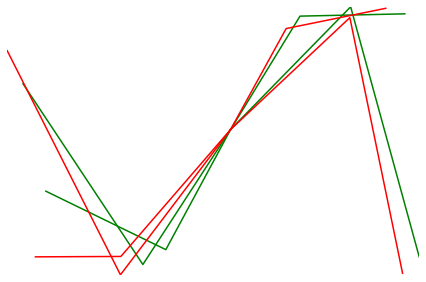

<Figure size 432x288 with 0 Axes>

In [25]:
compare_states(batch_Y[0], batch_Y_hat[0], overlap=True)            # animation of joints

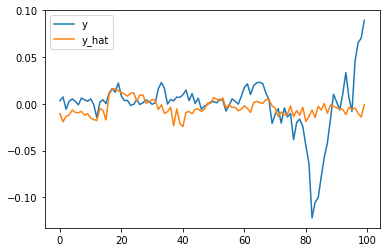

In [18]:
plot_velocity_curve(true=batch_Y[5, :, 0], pred=batch_Y_hat[1, :, 0]) # x-velocity

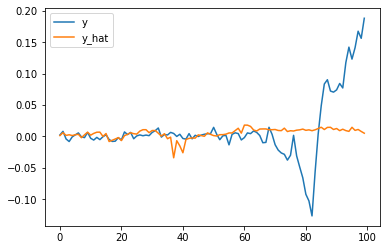

In [19]:
plot_velocity_curve(true=batch_Y[5, :, 1], pred=batch_Y_hat[1, :, 1]) # y-velocity

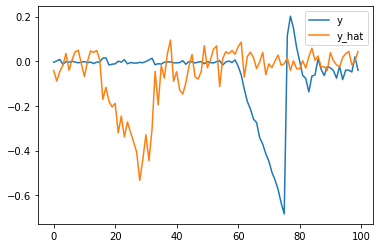

In [20]:
plot_velocity_curve(true=batch_Y[5, :, 2], pred=batch_Y_hat[1, :, 2]) # y-velocity

In [98]:
n = 10
t=10
Y_hat = vrnn.predict(X=X[n:n+1], A=A[n:n+1], Y=Y[n:n+1], lookahead=t)

In [99]:
Y_hat.shape

(1, 100, 21)

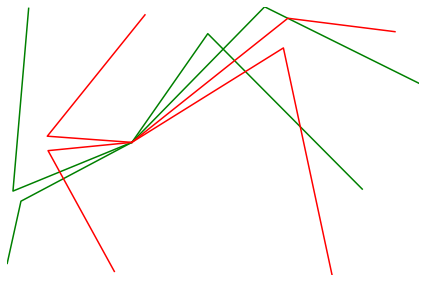

<Figure size 432x288 with 0 Axes>

In [91]:
compare_states(Y_hat[0], Y[n], overlap=True)            # animation of joints

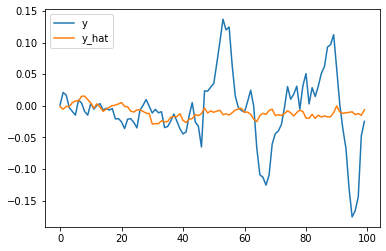

In [100]:
plot_velocity_curve(true=Y[n, :, 0].data.cpu().numpy(), pred=Y_hat[0, :, 0]) # x-velocity

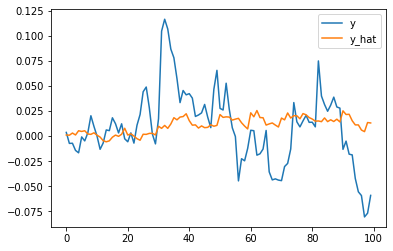

In [101]:
plot_velocity_curve(true=Y[n, :, 1].data.cpu().numpy(), pred=Y_hat[0, :, 1]) # y-velocity

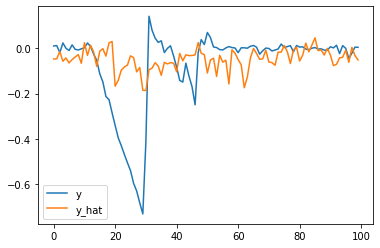

In [102]:
plot_velocity_curve(true=Y[n, :, 2].data.cpu().numpy(), pred=Y_hat[0, :, 2]) # z-velocity